In [51]:
import anndata as ad
import scanpy as sc
import numpy as np
import warnings

In [52]:
adata = sc.read_h5ad('GSE184290_data.h5ad')

In [53]:
# was stored as a float64 - conver to to 32
adata.X = adata.X.astype(np.float32)
adata.X.dtype

dtype('float32')

In [54]:
adata.var_names

Index(['Mrpl15', 'Lypla1', 'Gm37988', 'Tcea1', 'Atp6v1h', 'Rb1cc1',
       '4732440D04Rik', 'Pcmtd1', 'Gm26901', 'Rrs1',
       ...
       'Pacrg', 'Scube3', 'H2-M5', 'Dazl', 'Zfp521', 'Slc27a6', 'Slc22a12',
       '1700092M07Rik', 'Cnnm1', 'Col17a1'],
      dtype='object', length=15547)

## QC - Purification Overview
To preprocess the cells for single-cell RNA sequencing in this study, the researchers focused on identifying and isolating specific lung macrophage populations—interstitial macrophages (IMs) and alveolar macrophages (AMs)—from both infected and control mice. For this, they used cell surface marker genes:

IMs were identified by expression of the marker gene cx3cr1 and being negative for siglecF.

AMs were identified by expression of the marker gene siglecF.

After sorting these populations using fluorescence-activated cell sorting (FACS), the researchers performed single-cell RNA sequencing (scRNA-seq). During data processing, they curated the dataset using the Immgen20 reference database to remove any non-macrophage cells, ensuring that only macrophages (identified by these marker genes) were included in the final analysis.

In summary, the key genes used to preprocess and identify the macrophage populations were cx3cr1 (for IMs) and siglecF (for AMs)

In [55]:
#general gene annotation to observe quality - we are already looking at the QC + pure set
# mitochondrial genes - high counts signal stressed, damaged, or dying genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")  # "MT-" for human, "Mt-" for mouse
# ribosomal genes - high expression, has the potential to obscure other biological signals, especially if cell cycle effects are not of primary interest
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var.head()

,mt,ribo
Mrpl15,False,False
Lypla1,False,False
Gm37988,False,False
Tcea1,False,False
Atp6v1h,False,False


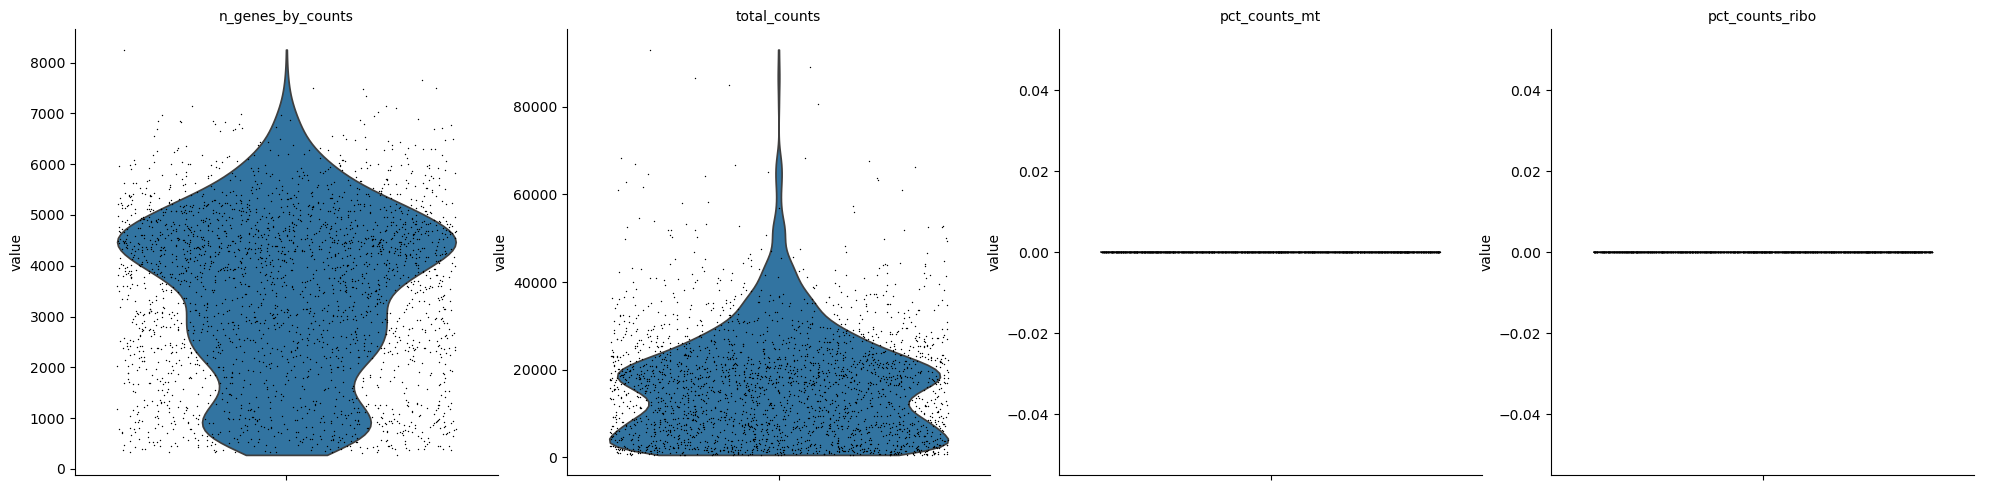

In [56]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"], jitter=0.4, multi_panel=True)

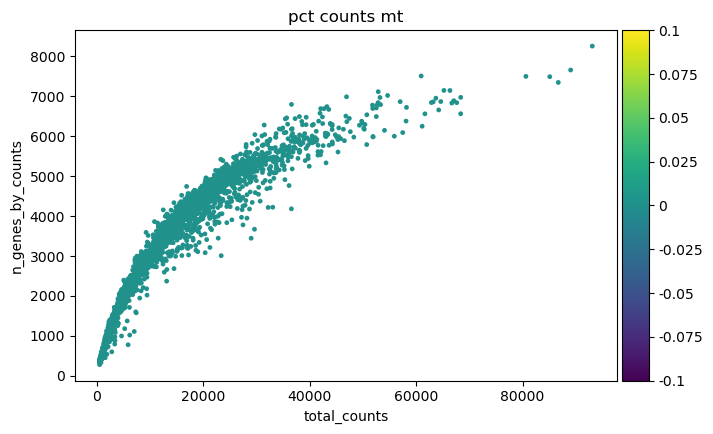

In [57]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

As apparent in the above graphs, the mitochondrial and ribosomal genes have been removed - deleted from the expression matrices. Why?

The decision to remove these gene sets is a common and often crucial step in scRNA-seq analysis, primarily driven by the desire to:

1. Reduce Technical Noise and Confounding Factors:

- Mitochondrial Genes: As discussed, a high proportion of mitochondrial reads is a strong indicator of stressed or dying cells. Even for cells deemed "good" after initial filtering, the remaining mitochondrial gene expression can be driven by cellular stress responses (e.g., due to dissociation, cold ischemia, or suboptimal cell handling) rather than genuine biological differences between cell types or states. By removing them, analysts aim to focus on transcriptional differences that reflect the true biological identity and function of the cells.
- Ribosomal Genes: Ribosomal proteins are essential for protein synthesis and are among the most highly expressed genes in a cell. Their expression is often tightly linked to cell proliferation, overall metabolic activity, and cell cycle. While biologically relevant, their high and sometimes variable expression can:
    - Dominate Variance: Ribosomal genes can contribute a disproportionately large amount to the total variance in the dataset. If they are not removed, downstream analyses like PCA (Principal Component Analysis) or UMAP (Uniform Manifold Approximation and Projection) might largely reflect differences in ribosomal gene expression, potentially obscuring more subtle and interesting biological distinctions between cell types or states.
    - Obscure Cell Type Identity: Two different cell types might both be highly proliferative (e.g., during development or immune activation), leading to similar high ribosomal gene expression. If ribosomal genes aren't accounted for, the analysis might incorrectly group these distinct cell types based on their proliferative state rather than their fundamental identity.
     - Confound Batch Effects: Variability in ribosomal gene expression can sometimes be influenced by technical factors (e.g., differences in library preparation efficiency or RNA quality across batches), leading to technical artifacts that look like biological differences.

2. Focus on Biologically Relevant Variation:
The primary goal of many scRNA-seq experiments is to identify and characterize distinct cell populations, discover novel cell states, and pinpoint differentially expressed genes that drive these biological differences. By removing genes that are primarily indicative of technical artifacts (MT genes) or general cellular processes (ribosomal genes) that might obscure more specific biological signals, the analysis becomes more focused and powerful.

3. Improve Computational Efficiency:
While less of a primary driver for removal in itself, removing highly expressed but less informative genes reduces the overall dimensionality of the gene expression matrix. This can slightly improve the speed and memory efficiency of downstream computational steps like clustering, dimensionality reduction, and differential expression analysis, especially for very large datasets.

#### QC thresholds (gene / cell) by batch

In [58]:
# check that my obs have the grou/condition as a column - title_x
adata.obs["title_x"].unique()


['AM_KP-', 'AM_KP+', 'IM_KP-', 'IM_KP+', 'AM_Control', 'IM_Control']
Categories (6, object): ['AM_Control', 'AM_KP+', 'AM_KP-', 'IM_Control', 'IM_KP+', 'IM_KP-']

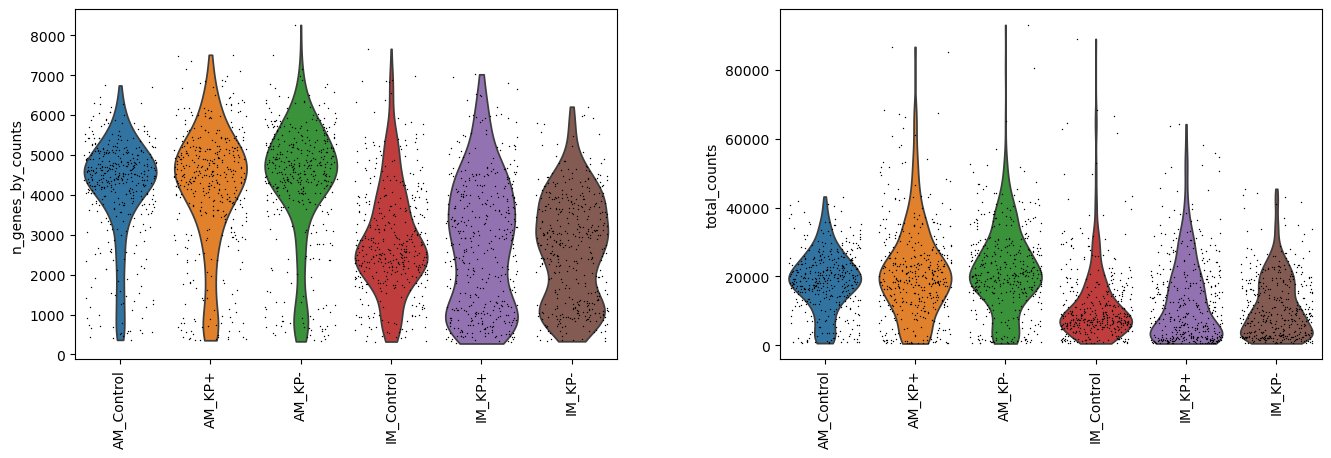

In [59]:
#sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)
#confirmed mt and ribos were zero in the global view earlier

# Plot only the relevant QC metrics, grouping by the 'title_x' column (the condition/group)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    groupby='title_x',
    jitter=0.4,
    multi_panel=True,
    rotation=90 # Optional: Rotate x-axis labels if they overlap due to many groups
)

Up to this point, the number of cells in each group have been 422. Applying the QC thresholds will change that (we can see that the "0"s in both graphs are of different sizes between groups.
 Quality > Quantity
- In the beginning however, its beneficial to be very permissive with filtering then revisit.
- We stick to the thresholds mentioned in the paper other than the "> 25% counts mapping to mitochondrial genes" as that was part of their "purification" of the dataset, including removing cell types that weren't of interest.


In [60]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection


In [61]:
# was stored as a float64 - conver to to 32
adata.X = adata.X.astype(np.float32)
adata.X.dtype


dtype('float32')

In [62]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning) #scrublet throws the float64 to 32 warnign for the 0.9 update
    sc.pp.scrublet(adata, batch_key="title_x")

### Normalization

In [63]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data:
sc.pp.log1p(adata)

### Feature Selection
"Strong overlap of replicates within the alveolar and interstitial samples indicated the absence of batch effect, therefore library integration with batch correction was not required."
Thus PCA can be performed on the data as a whole without need for seperations and combination of the found HVGs




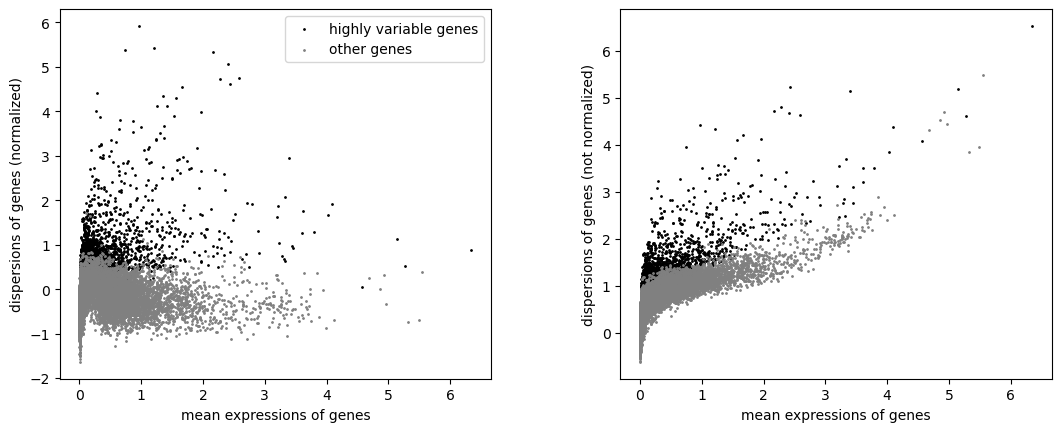

In [64]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="title_x")
sc.pl.highly_variable_genes(adata)

On the normalized graph, we have a good amount of highly variables genes (HVGs) - high on the Y axis (dispersion) and they land in the middle and left on our x-axis (mean expression) suggesting we have a decent set of HVGs with a few possible housekeeping genes in the mix.


### Dimensionality Reduction
Since the paper asserted there was no significant batch effect, this too can be done on the combined data.
- Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
- Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function {func}`~scanpy.tl.leiden` or {func}`~scanpy.tl.tsne`. In our experience, often a rough estimate of the number of PCs does fine.

/home/brian/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:213: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


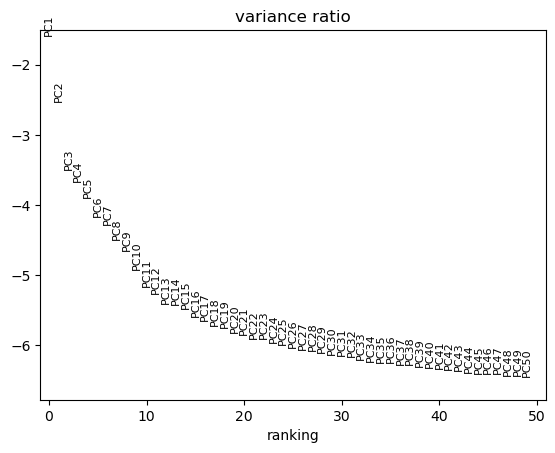

In [65]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### Visualization
Compute the neighborhood graph of cells using the PCA representation of the data matrix.

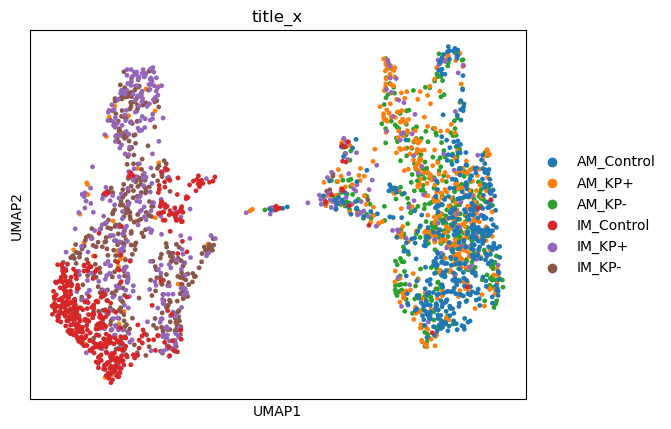

In [67]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="title_x")

The UMAP looks good because it demonstrates successful separation of the known biological populations while showing good mixing of technical replicates (conditions) within those populations.

Here's a summary of why it indicates a well-processed and interpretable dataset:

1. Clear Separation of Macrophage Subtypes (AM vs IM):

- The plot shows two large, distinct clusters. One cluster is predominantly composed of cells from the AM_Control, AM_KP+, and AM_KP- groups (blue, orange, green dots). The other distinct cluster is predominantly composed of cells from IM_Control, IM_KP+, and IM_KP- groups (red, purple, brown dots).
- This strong spatial separation is expected and desirable because Alveolar Macrophages (AMs) and Interstitial Macrophages (IMs) are biologically distinct cell types, residing in different anatomical niches and having different gene expression profiles. This confirms that the primary biological signal (macrophage subtype identity) is clearly captured and drives the major separation in the UMAP.

2. Good Mixing of Conditions Within Macrophage Subtypes (Absence of Batch Effect):

- Within the larger AM cluster, the cells from AM_Control (blue), AM_KP+ (orange), and AM_KP- (green) are largely intermingled. They are not forming distinct, separate sub-clusters based purely on their condition.
- Similarly, within the larger IM cluster, the IM_Control (red), IM_KP+ (purple), and IM_KP- (brown) cells show good mixing.
- This indicates that there is no major "batch effect" confounding your conditions. If there were strong batch effects, you would expect cells from each specific condition to form their own distinct sub-clusters, even if they belong to the same macrophage type. The intermingling suggests that any observed differences within the AM or IM clusters are more likely due to the biological effects of the KP-/KP+/Control treatments rather than technical variations between how those samples were processed. This aligns with the paper's claim of no batch effect, leading them to conclude that library integration with batch correction was not required.

### Clustering

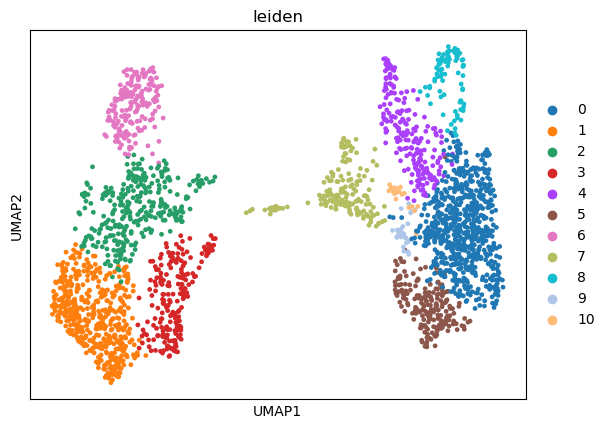

In [72]:
sc.tl.leiden(adata, resolution=0.5) # You can adjust resolution (e.g., 0.5, 1.0, etc.)
sc.pl.umap(adata, color=["leiden"])

### Reassess QC and Cell Filtering

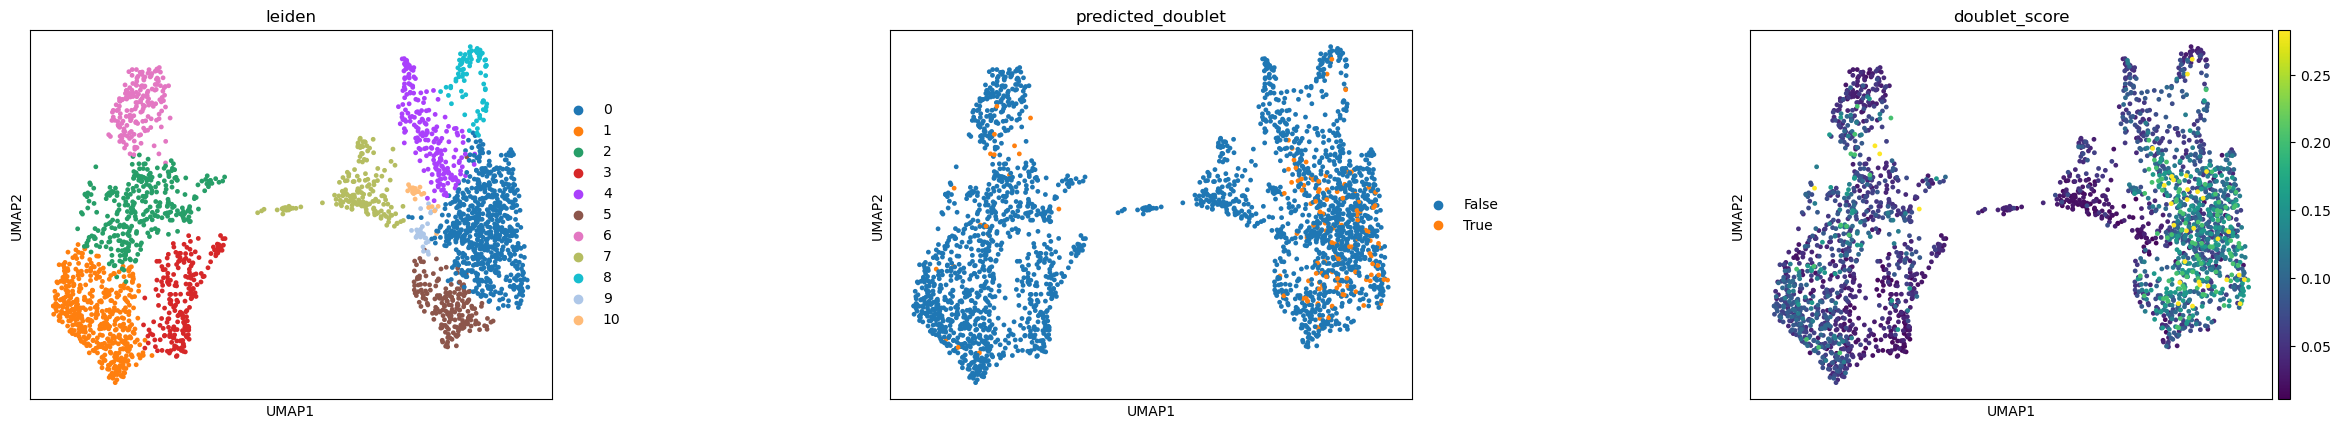

In [73]:
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
)

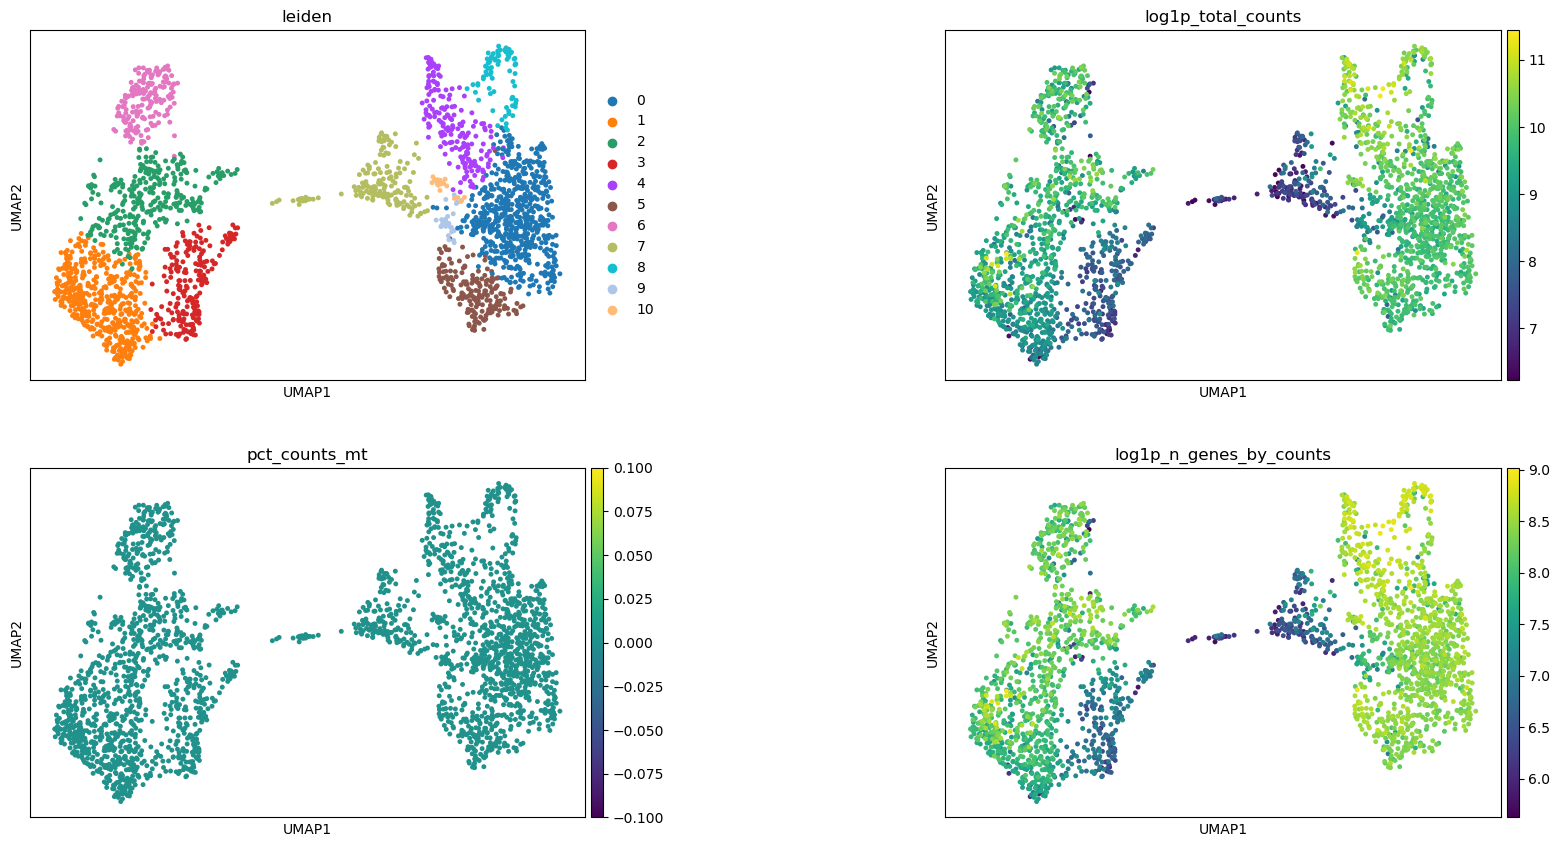

In [74]:
#subset out the the doublets:
adata = adata[~adata.obs["predicted_doublet"].to_numpy()].copy()
sc.pl.umap(
    adata, color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"], wspace=0.5, ncols=2
)

### Save Prog

In [76]:
# Define the file path where you want to save it
output_file = "QCed_GSE184290.h5ad"

# Save the AnnData object
adata.write(output_file)